##Machine Translation Using a Seq2Seq Architecture
© 2023, Zaka AI, Inc. All Rights Reserved.

---
The goal of this colab is to get you more familiar with the Seq2Seq models and their challenges. For this reason, you will be working on machine translation problem where we would have a sentence as input (in english), and the output is gonna be the translated sentence (in french). So just like what happens with Google Translate.


**Just to give you a heads up:** We won't be having a model performing like Google translate, but at least we will have an idea about how Google Translate works and the challenges that exist with a translation problem.  

## Importing Libraries

We start by importing numpy and pandas and then we can add the rest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nasam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We clone the github repository where our data exists. Here is the github link: https://github.com/zaka-ai/machine_learning_certification/tree/main/Challenge%207 

## Getting the data

In [2]:
#Test Your Zaka
!git clone https://github.com/zaka-ai/machine_learning_certification.git

%cd machine_learning_certification

^C
c:\Users\Nasam\Downloads\machine_learning_certification


We read the english sentences in a dataframe named "english", and the french sentences in a dataframe named "french"

In [ ]:
#Test Your Zaka (English)
english = pd.read_csv('/content/machine_learning_certification/Challenge 7/en.csv', names=['en_sentences'], header=None)
english.head()

,en_sentences
0,"new jersey is sometimes quiet during autumn , ..."
1,the united states is usually chilly during jul...
2,"california is usually quiet during march , and..."
3,the united states is sometimes mild during jun...
4,"your least liked fruit is the grape , but my l..."


In [ ]:
#Test Your Zaka (French)
french = pd.read_csv('/content/machine_learning_certification/Challenge 7/fr.csv', names=['fr_sentences'], header=None)
french.head()

,fr_sentences
0,new jersey est parfois calme pendant l' automn...
1,les états-unis est généralement froid en juill...
2,"california est généralement calme en mars , et..."
3,"les états-unis est parfois légère en juin , et..."
4,"votre moins aimé fruit est le raisin , mais mo..."


**How many sentences does each of the files contain?**

In [ ]:
#Test Your Zaka
print("number of english sentences:", english.shape[0])
print('number of french sentences:', french.shape[0])

number of english sentences: 137860
number of french sentences: 137860


Now let us concatenate the 2 dataframes into one dataframe that we call **df** where one column has the english senetnces and the other has the french sentences

In [ ]:
#Test Your Zaka
df = pd.concat([english, french], axis = 1)
df.head()

,en_sentences,fr_sentences
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


Let's name the columns as **English** and **French** so that we access them easier.

In [ ]:
#Test Your Zaka
df.rename(columns={'en_sentences':'English', 'fr_sentences':'French'}, inplace=True)
df.head()

,English,French
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


Pick a sentence and print it in both languages

In [ ]:
#Test Your Zaka
print(df.loc[3, 'English'])
print(df.loc[3, 'French'])

the united states is sometimes mild during june , and it is cold in september .
les états-unis est parfois légère en juin , et il fait froid en septembre .


##Cleaning Data

The data that we have is almost clean as we can see, we just need to remove the punctuations inside of it.

In [ ]:
#Test Your Zaka
def remove_punctuation(text):
    translator = str.maketrans('', '', "!\"#$%&'()*+,-./:;<=>?@[\]^_{|}~")
    return text.translate(translator)

df_clean = df.applymap(remove_punctuation)

Make sure that the punctuation is removed by printing the example that you printed earlier.

In [ ]:
#Test Your Zaka
print(df_clean.loc[3, 'English'])
print(df_clean.loc[3, 'French'])

the united states is sometimes mild during june  and it is cold in september 
les étatsunis est parfois légère en juin  et il fait froid en septembre 


##Exploring the Data

Add a column **ENG Length** to the dataset that shows how many words does a sentence contain, and do the same for french in a column called **FR Length**

In [ ]:
#Test Your Zaka
df_clean['ENG Length'] = df_clean['English'].str.strip().apply(lambda x: len(x.split()))

In [ ]:
#Test Your Zaka
df_clean['FR Length'] = df_clean['French'].str.strip().apply(lambda x: len(x.split()))

Visualize the distribution of the lengths of english sentences and french sentences.

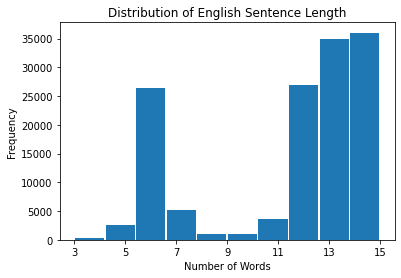

In [ ]:
#Test Your Zaka
plt.hist(df_clean['ENG Length'], rwidth=0.95)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of English Sentence Length')
plt.xticks(range(min(df_clean['ENG Length']), max(df_clean['ENG Length'])+1, 2))
plt.show()

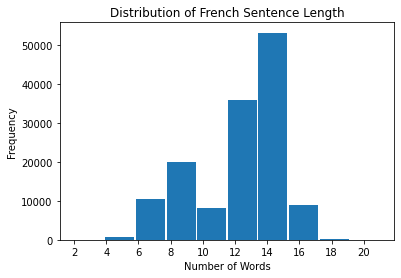

In [ ]:
#Test Your Zaka
plt.hist(df_clean['FR Length'], rwidth=0.95)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of French Sentence Length')
plt.xticks(range(min(df_clean['FR Length']), max(df_clean['FR Length']+1), 2))
plt.show()

Get the maximum length of an english sentence and the maximum length of a french sentence. 

In [ ]:
#Test Your Zaka
max_eng_length = df_clean['ENG Length'].max()
max_fr_length = df_clean['FR Length'].max()

print('Maximum length of an English sentence:', max_eng_length)
print('Maximum length of a French sentence:', max_fr_length)

Maximum length of an English sentence: 15
Maximum length of a French sentence: 21


##Preprocessing the Data

In order for the data to be fed to the model, it has to be tokenized and padded. 

####Tokenization

**To tokenize english and french sentences, we can use only one tokenizer. True or False?**

It's generally a good practice to use language-specific tokenizers for each language to avoid any mistakes related to the grammer for example. However, True as long as the both languages words are saperated by spaces or the same approach.

Tokenize the sentences that we have.

In [ ]:
df['English']=df['English'].apply(lambda x: 'ST '+x.strip().lower()+' EN')
df['French']=df['French'].apply(lambda x: 'ST '+x.strip().lower()+' EN')

In [ ]:
#Test Your Zaka
# English tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df['English'].values)
eng_seq = eng_tokenizer.texts_to_sequences(df['English'].values)

# French tokenizer
fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(df['French'].values)
fr_seq = fr_tokenizer.texts_to_sequences(df['French'].values)

**How many unique words do we have in english and in french?**

In [ ]:
#Test Your Zaka
num_eng_words=len(eng_tokenizer.word_index)+1
num_fr_words=len(fr_tokenizer.word_index)+1

print('Number of unique English words:', num_eng_words)
print('Number of unique French words:', num_fr_words)

Number of unique English words: 202
Number of unique French words: 346


####Padding

**What should be the length of the sequences that we have after padding?**

The max length detected in the dataset which is 21 for French and 15 for English. Then, 2 is added for the "ST" start and "EN" end char.

Perform padding on the sequences that we have.

In [ ]:
#Test Your Zaka
eng_pad_seq = pad_sequences(eng_seq, maxlen=max_eng_length+2, padding='post')
fr_pad_seq = pad_sequences(fr_seq, maxlen=max_fr_length+2, padding='post')

##Modeling

After preprrocessing the data, we can build our model. Start by building a baseline architecture relying on one directional RNNs, LSTMs, or GRUs. It will be good to lookup how to build Seq2Seq models, there are some new layers that will help you like RepeatVector and TimeDistributed.

In [ ]:
fr_pad_seq_noST = np.roll(fr_pad_seq, shift=-1, axis=-1)
fr_pad_seq_noST[:,-1] = 0

In [ ]:
# Encoder
E_input = Input(shape=(max_eng_length+2,))                               
E_embedding  = Embedding(input_dim=num_eng_words, output_dim=50)(E_input) 
_, Eh, Ec = LSTM(units=512, return_state=True)(E_embedding)       

# Decoder layer definitions
decoder_embedding = Embedding(input_dim=num_fr_words, output_dim=50)
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_dense = Dense(num_fr_words, activation='softmax')

# Decoder in train mode
D_input = Input(shape=(max_fr_length+2,))                         
D_embedding  = decoder_embedding(D_input)                                            
D_lstm, _, _ = decoder_lstm(D_embedding , initial_state=[Eh, Ec]) #Eh and Ec are the final hidden state and cell state of the encoder           
D_output = decoder_dense(D_lstm)                                    

Compile and train the model. 
**FYI:** While specifying the architecture of your model and the number of epochs for training, keeep in your mind that your model might take A LOT of time to train.

In [ ]:
#Test Your Zaka
model = tf.keras.Model(inputs=[E_input, D_input], outputs=D_output)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 50)       10100       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 23, 50)       17300       ['input_2[0][0]']                
                                                                                              

In [ ]:
model.fit(x=[eng_pad_seq, fr_pad_seq], y=np.expand_dims(fr_pad_seq_noST, axis=-1),
          batch_size=1024, epochs=20, validation_split=0.2, workers=2, use_multiprocessing=True)

Epoch 1/20
108/108 [==============================] - 27s 164ms/step - loss: 2.6263 - sparse_categorical_accuracy: 0.4781 - val_loss: 1.8644 - val_sparse_categorical_accuracy: 0.5825
Epoch 2/20
108/108 [==============================] - 13s 119ms/step - loss: 1.3298 - sparse_categorical_accuracy: 0.6567 - val_loss: 0.9350 - val_sparse_categorical_accuracy: 0.7293
Epoch 3/20
108/108 [==============================] - 12s 114ms/step - loss: 0.7734 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.7816
Epoch 4/20
108/108 [==============================] - 13s 117ms/step - loss: 0.6034 - sparse_categorical_accuracy: 0.7970 - val_loss: 0.5600 - val_sparse_categorical_accuracy: 0.8091
Epoch 5/20
108/108 [==============================] - 13s 122ms/step - loss: 0.5352 - sparse_categorical_accuracy: 0.8140 - val_loss: 0.5086 - val_sparse_categorical_accuracy: 0.8240
Epoch 6/20
108/108 [==============================] - 13s 121ms/step - loss: 0.5485 -

Define a function that gets an input sentence in english and gives the output sentence in the french language.

In [ ]:
#Test Your Zaka
def eng_fr_translation_model1(input):
  st_input=remove_punctuation(input)
  st_input= 'ST '+st_input.strip().lower()+' EN'
  st_input=eng_tokenizer.texts_to_sequences([st_input])
  st_input=pad_sequences(st_input, maxlen=max_eng_length+2, padding='post')
  
  encoder = tf.keras.Model(inputs=E_input, outputs=[Eh, Ec])

  Sh_init = Input(shape=(512,))                                          
  Sc_init = Input(shape=(512,))                                          
  S_input = Input(shape=(1,),)                         
  S_embedding  = decoder_embedding(S_input)                                    
  S_lstm, Sh, Sc = decoder_lstm(S_embedding , initial_state=[Sh_init, Sc_init]) 
  S_output = decoder_dense(S_lstm) 

  sampler = tf.keras.Model(inputs=[S_input, Sh_init, Sc_init], outputs=[S_output, Sh, Sc])

  st_h, st_c = encoder.predict(st_input)

  st_input = fr_tokenizer.word_index['st']
  st_input = np.array([[st_input]])  

  prediction_tok = []                     
  for i in range(num_fr_words):
      probs, st_h, st_c = sampler.predict([st_input, st_h, st_c])
      
      st_input = probs.argmax(axis=-1)
      
      token = probs.argmax()
      if token != fr_tokenizer.word_index['en']:
        prediction_tok.append(token)
      
      if token == fr_tokenizer.word_index['en']:

          break    

  words = [fr_tokenizer.index_word[x] for x in prediction_tok if x in fr_tokenizer.index_word]
  words=' '.join(words)

  return words

Test the following sentence

In [ ]:
input = "she is driving the truck"

#Test Your Zaka
eng_fr_translation_model1(input)

1/1 [==============================] - 0s 22ms/step


'elle conduit le nouveau camion blanc'

Try to improve your model by modifying the architecture to take into account bidirectionality which is very useful in Machine Translation. Create a new model called model2

In [ ]:
# Encoder
E_input_2 = Input(shape=(max_eng_length+2,))                               
E_embedding_2 = Embedding(input_dim=num_eng_words, output_dim=50)(E_input_2) 
_, Eh1_2, Ec1_2, Eh2_2, Ec2_2 = Bidirectional(LSTM(units=512, return_state=True))(E_embedding_2)      
Eh_2 = Concatenate()([Eh1_2, Eh2_2])
Ec_2 = Concatenate()([Ec1_2, Ec2_2])

# Decoder layer definitions
decoder_embedding_2 = Embedding(input_dim=num_fr_words, output_dim=50)
decoder_lstm_2 = Bidirectional(LSTM(512, return_sequences=True, return_state=True))
decoder_dense_2 = Dense(num_fr_words, activation='softmax')

# Decoder in train mode
D_input_2 = Input(shape=(max_fr_length+2,))                         
D_embedding_2 = decoder_embedding_2(D_input_2)                                            
D_lstm_2, _, _, _, _ = decoder_lstm_2(D_embedding_2, initial_state=[Eh_2[:, :512], Ec_2[:, :512], Eh_2[:, 512:], Ec_2[:, 512:]])           
D_output_2 = decoder_dense_2(D_lstm_2) 


compile and train your new model.

In [ ]:
#Test Your Zaka
model2 = tf.keras.Model(inputs=[E_input_2, D_input_2], outputs=D_output_2)
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])    
model2.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 17, 50)       10100       ['input_50[0][0]']               
                                                                                                  
 bidirectional_14 (Bidirectiona  [(None, 1024),      2306048     ['embedding_14[0][0]']           
 l)                              (None, 512),                                                     
                                 (None, 512),                                                     
                                 (None, 512),                                              

In [ ]:
model2.fit(x=[eng_pad_seq, fr_pad_seq], y=np.expand_dims(fr_pad_seq_noST, axis=-1),
          batch_size=1028, epochs=10, validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 36s 263ms/step - loss: 2.4997 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6689 - val_sparse_categorical_accuracy: 0.6042
Epoch 2/10
108/108 [==============================] - 29s 269ms/step - loss: 1.0996 - sparse_categorical_accuracy: 0.7083 - val_loss: 0.6671 - val_sparse_categorical_accuracy: 0.8075
Epoch 3/10
108/108 [==============================] - 29s 265ms/step - loss: 0.4187 - sparse_categorical_accuracy: 0.8907 - val_loss: 0.1931 - val_sparse_categorical_accuracy: 0.9642
Epoch 4/10
108/108 [==============================] - 28s 256ms/step - loss: 0.0890 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.0356 - val_sparse_categorical_accuracy: 0.9964
Epoch 5/10
108/108 [==============================] - 28s 262ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0149 - val_sparse_categorical_accuracy: 0.9987
Epoch 6/10
108/108 [==============================] - 29s 265ms/step - loss: 0.0110 -

Define a new function that relies on your new model to make predictions.

In [ ]:
#Test Your Zaka
def eng_fr_translation_model2(input):
  st_input=remove_punctuation(input)
  st_input= 'ST '+st_input.strip().lower()+' EN'
  st_input=eng_tokenizer.texts_to_sequences([st_input])
  st_input=pad_sequences(st_input, maxlen=max_eng_length+2, padding='post')
  encoder = tf.keras.Model(inputs=E_input_2, outputs=[Eh1_2, Ec1_2, Eh2_2, Ec2_2])

  Sh_init1 = Input(shape=(512,))                                          
  Sc_init1 = Input(shape=(512,))    
  Sh_init2 = Input(shape=(512,))                                          
  Sc_init2 = Input(shape=(512,))                                       
  S_input = Input(shape=(1,),)                         
  S_embedding  = decoder_embedding_2(S_input)                                    
  S_lstm, Sh1_2, Sc1_2, Sh2_2, Sc2_2 = decoder_lstm_2(S_embedding , initial_state=[Sh_init1, Sc_init1, Sh_init2, Sc_init2]) 
  S_output = decoder_dense_2(S_lstm) 

  sampler = tf.keras.Model(inputs=[S_input, Sh_init1, Sc_init1, Sh_init2, Sc_init2], outputs=[S_output, Sh1_2, Sc1_2, Sh2_2, Sc2_2])

  st_h1, st_c1, st_h2, st_c2 = encoder.predict(st_input)

  st_input = fr_tokenizer.word_index['st']
  st_input = np.array([[st_input]])  

  prediction_tok = []                     
  for i in range(num_fr_words):
      probs, st_h1, st_c1, st_h2, st_c2 = sampler.predict([st_input, st_h1, st_c1, st_h2, st_c2])
      
      st_input = probs.argmax(axis=-1)
      
      token = probs.argmax()
      if token != fr_tokenizer.word_index['en']:
        prediction_tok.append(token)
      
      if token == fr_tokenizer.word_index['en']:

          break    

  words = [fr_tokenizer.index_word[x] for x in prediction_tok if x in fr_tokenizer.index_word]
  words=' '.join(words)

  return words

In [ ]:
input = "she is driving the truck"

#Test Your Zaka
eng_fr_translation_model2(input)

1/1 [==============================] - 0s 23ms/step


'il conduisait cette nouvelle'

**What is another adjustment in terms of architecture that you might be able to do to improve your model?**


we can add a RepeatVector and TimeDistributed Layers. RepeatVector repeats the input layer n-times. TimeDistributed applies a layer to every temporal slice of the input. It helps to keep one-to-one relations with input and its corresponding output.
We can also add an Attention Layer. Attention models help relate input sequence units disregarding distance between them in space and time, at the same time make sequence data processing more parallelizable.

**What are some additional ways that we can do to improve the performance of our model?**

Our dataset includes very limited number of unique words, increasing the training set will get us better results. we can also use data augmentation which increases the diversity of the data and help the model better generalize to unseen data. We could also consider fine-tuning. Additionally, as the bi-lstm, did not perform good, we could try another prediction method or a different neurons or layer number. 